In [1]:
!pip install -q --upgrade pip
!pip install -q --upgrade numpy
!pip install -q --upgrade scipy
!pip install -q --upgrade matplotlib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import os
from scipy.signal import find_peaks
from scipy.signal import butter, filtfilt, iirfilter, freqs, lfilter, lfilter_zi
import json

In [2]:
logFilePath = "../../../logs"

In [6]:
def findLatestLogFile():
    list_of_files = glob.glob(os.path.join(logFilePath, '*.log'))
    latest_file = max(list_of_files, key=os.path.getctime)
    print("Latest file: ", latest_file)
    return latest_file

In [12]:
def readADCData(logfile):
    # Each line is formatted like this:
    # T:306232,A:2022

    # Log data
    timestamps = []
    adc_values = []

    # Read the file
    with open(logfile) as f:
        lines = f.readlines()

        # Iterate over each line
        for line in lines:

            # Check if the line is a sample
            if "T:" in line and "A:" in line:
                # Extract the timestamp and the ADC value
                parts = line.split(',')
                timestamp = int(parts[0].split(':')[1])
                adc_value = int(parts[1].split(':')[1])

                # Append to the list
                timestamps.append(timestamp)
                adc_values.append(adc_value)

    # Debug
    print("Read", len(timestamps), "samples")

    # Convert to numpy arrays
    timestamps = np.array(timestamps)
    adc_values = np.array(adc_values)
    
    return timestamps, adc_values

Latest file:  ../../../logs/20240215-170001.log
Read 207686 samples


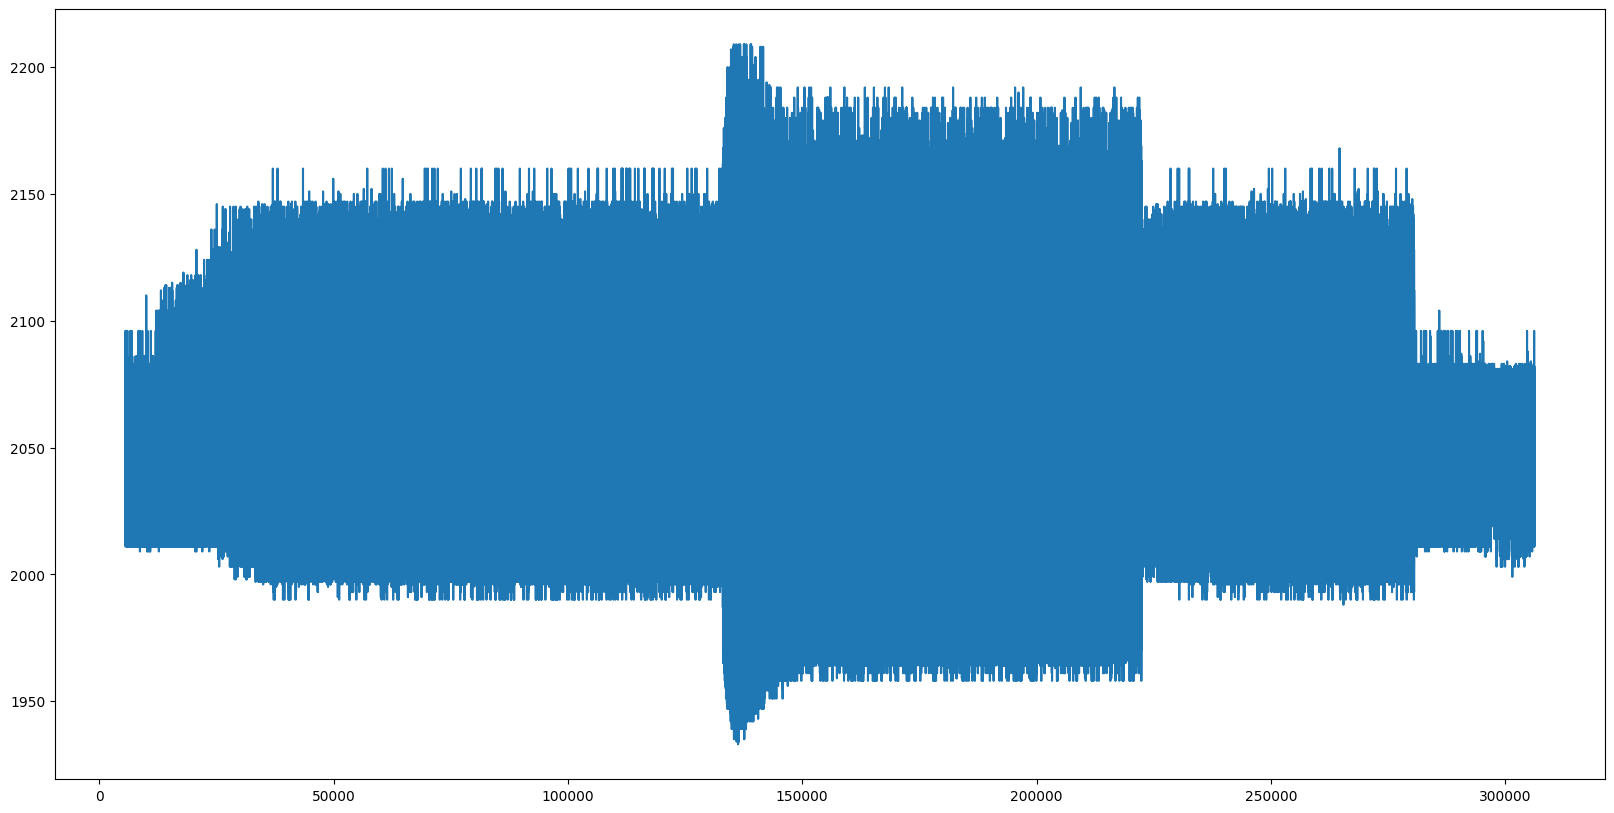

In [14]:
if __name__ == "__main__":

    # Set plot size
    matplotlib.rcParams['figure.figsize'] = [20, 10]
    
    # Find the latest log file
    logfile = findLatestLogFile()

    # Read the data
    timestamps, adc_ch1 = readADCData(logfile)

    # Plot the data
    plt.plot(timestamps, adc_ch1)

    # Show the plot
    plt.show()

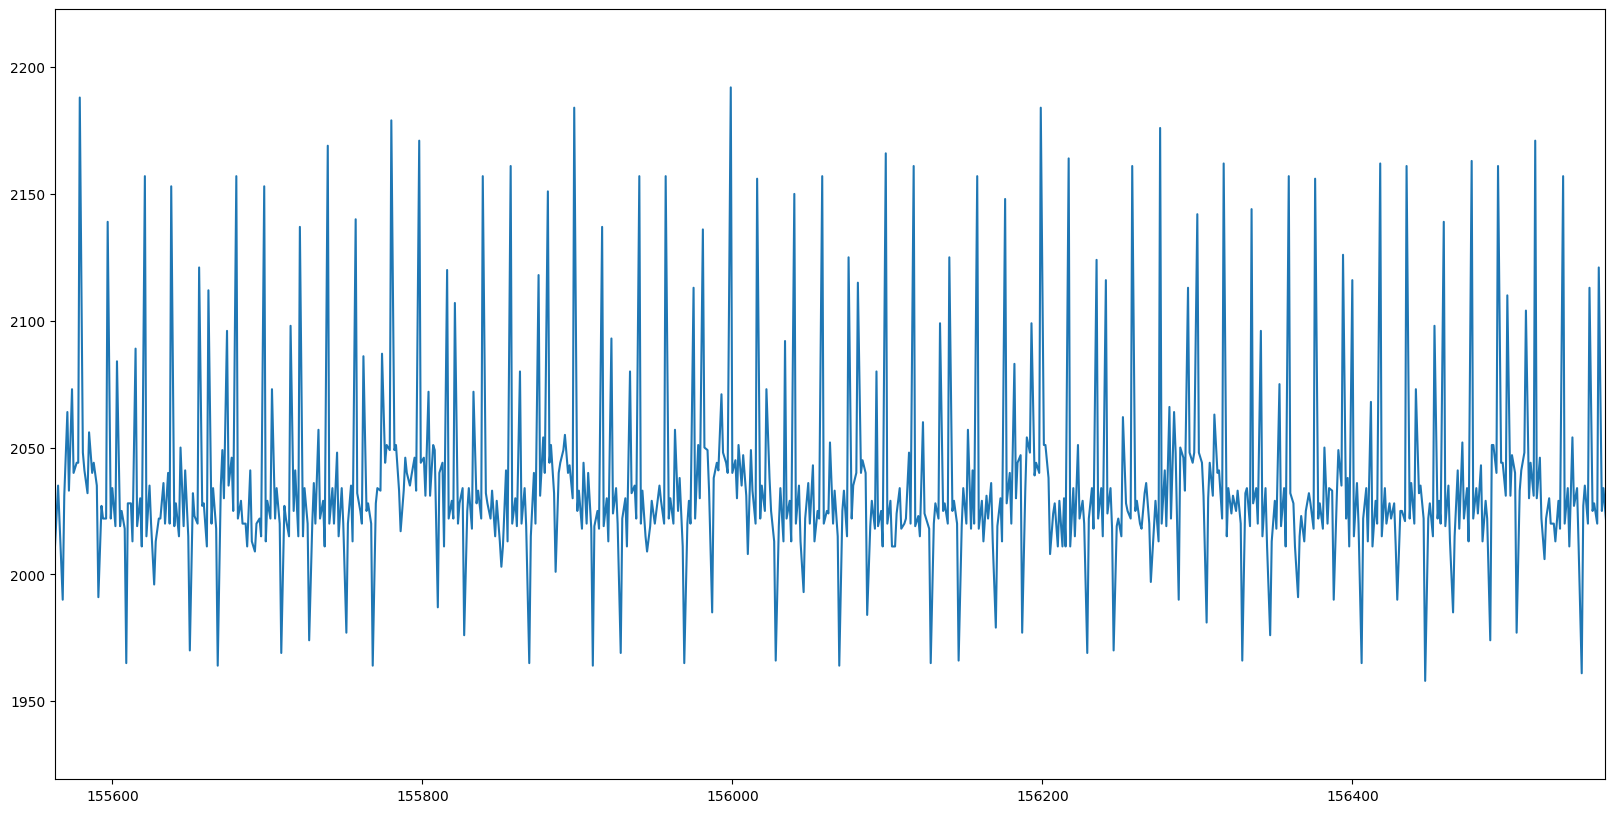

In [19]:
# Plot a chunk of data in a large plot
plt.plot(timestamps, adc_ch1)
plt.xlim([timestamps[0]+150000, timestamps[0] + 151000])
plt.show()